# Stock Prediction using LSTM

# Importing Modules

In [3]:
pip install numpy pandas keras tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Reading the Dataset

In [37]:
df=pd.read_csv("TSLA (2).csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [38]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300
2415,2020-02-03,673.690002,786.140015,673.520020,780.000000,780.000000,47065000


Displaying Basic Statistics about Data

In [39]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035004,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


Sorting the Data

Checking for Null Values

In [40]:
NAN = [(c, df[c].isnull().mean()*100) for c in df]
NAN = pd.DataFrame(NAN, columns=['column_name', 'percentage'])
NAN

,column_name,percentage
0,Date,0.0
1,Open,0.0
2,High,0.0
3,Low,0.0
4,Close,0.0
5,Adj Close,0.0
6,Volume,0.0


In [41]:
srt = df.sort_values(by='Date')
srt.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [42]:
srt.reset_index(inplace=True)

In [43]:
srt.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


# Data Visualization

Plotting the graph for the Data and Close

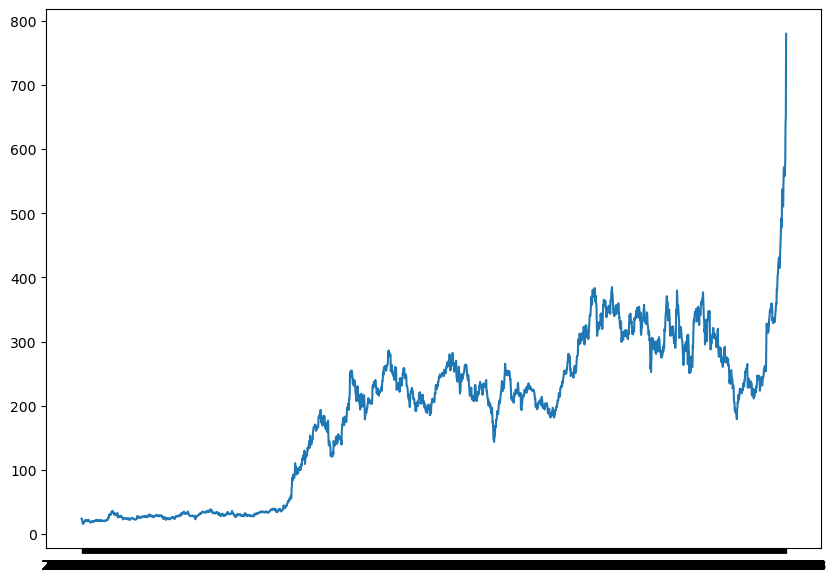

In [44]:
plt.figure(figsize=(10,7))
plt.plot(srt['Date'], srt['Close'])

In [45]:
close_srt = srt['Close']
close_srt

0        23.889999
1        23.830000
2        21.959999
3        19.200001
4        16.110001
           ...    
2411    566.900024
2412    580.989990
2413    640.809998
2414    650.570007
2415    780.000000
Name: Close, Length: 2416, dtype: float64

# Feature Scaling(MinMax Scaler)

In [46]:
scaler = MinMaxScaler(feature_range=(0,1))
close_srt = scaler.fit_transform(np.array(close_srt).reshape(-1,1))
close_srt


array([[0.01058623],
       [0.01050772],
       [0.00806072],
       ...,
       [0.81786181],
       [0.83063335],
       [1.        ]])

# Splitting the DataSet

In [47]:
train_size = int(len(close_srt)*0.7)
test_size = len(close_srt) - train_size
train_data, test_data = close_srt[0:train_size,:],close_srt[train_size:len(close_srt),:1]

In [48]:
train_data.shape

(1691, 1)

In [49]:
test_data.shape

(725, 1)

# Converting an array of values into a dataset matrix

In [50]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

# Reshaping of Dataset

In [55]:
time_step = 1000
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [56]:
print(X_train.shape), print(y_train.shape)

(690, 1000)
(690,)


(None, None)

In [57]:
test_data.shape

(725, 1)

In [58]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], test_data.shape[1], 1)

In [59]:
X_train

array([[[0.01058623],
        [0.01050772],
        [0.00806072],
        ...,
        [0.27323999],
        [0.28247841],
        [0.27652446]],

       [[0.01050772],
        [0.00806072],
        [0.0044491 ],
        ...,
        [0.28247841],
        [0.27652446],
        [0.27740119]],

       [[0.00806072],
        [0.0044491 ],
        [0.00040565],
        ...,
        [0.27652446],
        [0.27740119],
        [0.2797566 ]],

       ...,

       [[0.02724418],
        [0.02843496],
        [0.02886679],
        ...,
        [0.30236848],
        [0.29979062],
        [0.29820728]],

       [[0.02843496],
        [0.02886679],
        [0.02925936],
        ...,
        [0.29979062],
        [0.29820728],
        [0.3014525 ]],

       [[0.02886679],
        [0.02925936],
        [0.02890604],
        ...,
        [0.29820728],
        [0.3014525 ],
        [0.31693274]]])

In [60]:
X_test

array([], shape=(0, 1, 1), dtype=float64)

# Creating LSTM Model

In [64]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1000,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [65]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1000, 50)          10400     
                                                                 
 lstm_7 (LSTM)               (None, 1000, 50)          20200     
                                                                 
 lstm_8 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Predicting and Checking Perfomance

In [66]:
model.fit(X_train, y_train, validation_split=0.1, epochs=60, batch_size=64, verbose=1)

Epoch 1/60
10/10 [==============================] - 25s 2s/step - loss: 0.0144 - val_loss: 0.0056
Epoch 2/60
10/10 [==============================] - 21s 2s/step - loss: 0.0028 - val_loss: 5.5531e-04
Epoch 3/60
10/10 [==============================] - 22s 2s/step - loss: 0.0012 - val_loss: 0.0020
Epoch 4/60
10/10 [==============================] - 23s 2s/step - loss: 8.3168e-04 - val_loss: 3.6786e-04
Epoch 5/60
10/10 [==============================] - 24s 2s/step - loss: 6.3533e-04 - val_loss: 0.0010
Epoch 6/60
10/10 [==============================] - 25s 3s/step - loss: 5.6229e-04 - val_loss: 4.6221e-04
Epoch 7/60
10/10 [==============================] - 24s 2s/step - loss: 5.3795e-04 - val_loss: 7.7704e-04
Epoch 8/60
10/10 [==============================] - 22s 2s/step - loss: 5.3292e-04 - val_loss: 5.1419e-04
Epoch 9/60
10/10 [==============================] - 24s 2s/step - loss: 5.1313e-04 - val_loss: 7.0385e-04
Epoch 10/60
10/10 [==============================] - 23s 2s/step - los

In [68]:
X_test=X_train

In [69]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

22/22 [==============================] - 6s 280ms/step


# Calculating the Perfomance 

In [70]:
import math
from sklearn.metrics import mean_squared_error

In [71]:
math.sqrt(mean_squared_error(y_train, train_predict))

0.0146696047770004

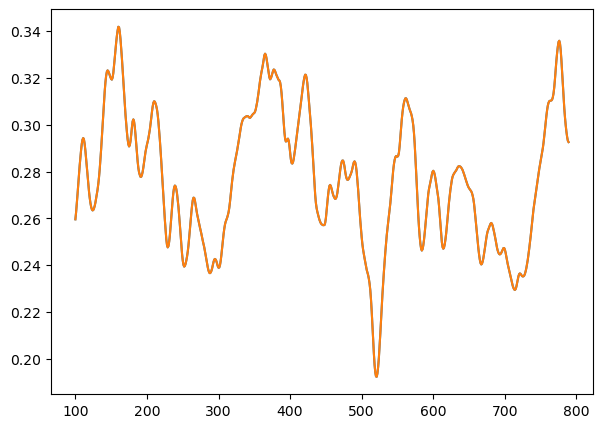

In [72]:
look_back = 100

trainPredictPlot = np.empty_like(close_srt)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(close_srt)
testPredictPlot[:, :] = np.nan
testPredictPlot[look_back:len(train_predict)+look_back, :] = test_predict

plt.figure(figsize=(7,5))

plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()